<a href="https://colab.research.google.com/github/jesuslimac/MINERIA-DE-DATOS/blob/main/Arbol_de_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [40]:
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

In [41]:
datos.head(3)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


In [42]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

In [43]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# One-hot-encoding de las variables categóricas
# ------------------------------------------------------------------------------
# Se identifica el nobre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough'
               )

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [44]:
# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# ------------------------------------------------------------------------------
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CompPrice         300 non-null    float64
 1   Income            300 non-null    float64
 2   Advertising       300 non-null    float64
 3   Population        300 non-null    float64
 4   Price             300 non-null    float64
 5   Age               300 non-null    float64
 6   Education         300 non-null    float64
 7   ShelveLoc_Bad     300 non-null    float64
 8   ShelveLoc_Good    300 non-null    float64
 9   ShelveLoc_Medium  300 non-null    float64
 10  Urban_No          300 non-null    float64
 11  Urban_Yes         300 non-null    float64
 12  US_No             300 non-null    float64
 13  US_Yes            300 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=123)

Profundidad del árbol: 5
Número de nodos terminales: 23


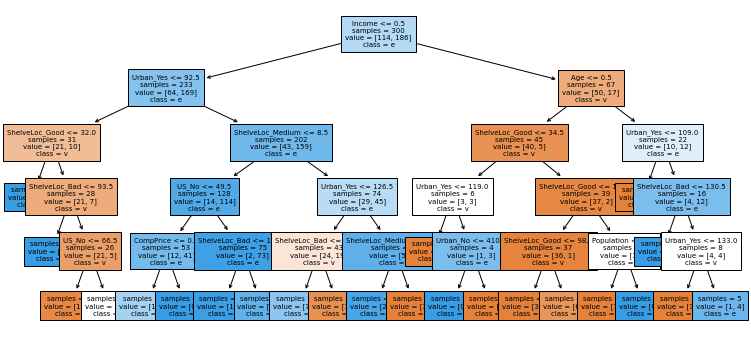

In [46]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

In [47]:
# Error de test del modelo
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test_prep,)

print("Matriz de confusión")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Matriz de confusión
-------------------


array([[29, 21],
       [ 7, 43]])

In [48]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 72.0 %


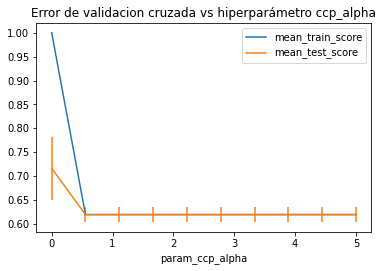

In [49]:
# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_prep, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [50]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

{'ccp_alpha': 0.0}

In [51]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 9
Número de nodos terminales: 49


In [52]:
# Error de test del modelo final
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test_prep)

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"El accuracy de test es: {100 * accuracy} %")

El accuracy de test es: 75.0 %
